# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [ ]:
!pip install -U captcha numpy matplotlib tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_lowercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

0123456789abcdefghijklmnopqrstuvwxyz


# 定义数据生成器

In [ ]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 测试生成器

Text(0.5, 1.0, 'icyv')

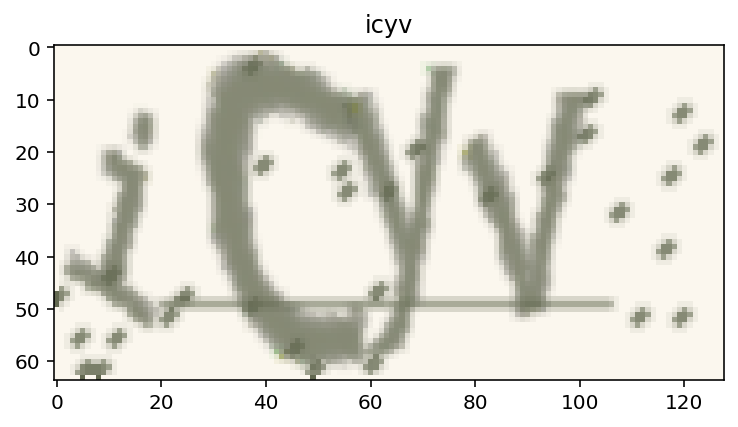

In [ ]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

# 网络结构可视化

可视化需要安装下面的包：

```sh
pip install pydot
sudo apt install graphviz
```

In [ ]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# plot_model(model, to_file='cnn.png', show_shapes=True)
# Image('cnn.png')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 128, 32)  128        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# 训练模型

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

<ipython-input-8-a4fd9e97b058>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,


Epoch 1/100
1000/1000 [==============================] - 540s 512ms/step - loss: 5.8486 - c1_loss: 1.4096 - c2_loss: 1.5280 - c3_loss: 1.5168 - c4_loss: 1.3942 - c1_accuracy: 0.6193 - c2_accuracy: 0.5868 - c3_accuracy: 0.5903 - c4_accuracy: 0.6242 - val_loss: 0.6117 - val_c1_loss: 0.1107 - val_c2_loss: 0.2044 - val_c3_loss: 0.2132 - val_c4_loss: 0.0834 - val_c1_accuracy: 0.9688 - val_c2_accuracy: 0.9428 - val_c3_accuracy: 0.9391 - val_c4_accuracy: 0.9744
Epoch 2/100
1000/1000 [==============================] - 522s 521ms/step - loss: 0.1196 - c1_loss: 0.0205 - c2_loss: 0.0405 - c3_loss: 0.0402 - c4_loss: 0.0184 - c1_accuracy: 0.9941 - c2_accuracy: 0.9883 - c3_accuracy: 0.9879 - c4_accuracy: 0.9949 - val_loss: 0.2380 - val_c1_loss: 0.0410 - val_c2_loss: 0.0860 - val_c3_loss: 0.0563 - val_c4_loss: 0.0547 - val_c1_accuracy: 0.9877 - val_c2_accuracy: 0.9752 - val_c3_accuracy: 0.9841 - val_c4_accuracy: 0.9858
Epoch 3/100
1000/1000 [==============================] - 527s 526ms/step - loss: 0

### 载入最好的模型继续训练一会

In [ ]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

<ipython-input-9-515c36f2dcc7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,


Epoch 1/100
1000/1000 [==============================] - 528s 514ms/step - loss: 0.0139 - c1_loss: 0.0017 - c2_loss: 0.0048 - c3_loss: 0.0056 - c4_loss: 0.0019 - c1_accuracy: 0.9995 - c2_accuracy: 0.9984 - c3_accuracy: 0.9984 - c4_accuracy: 0.9995 - val_loss: 0.0220 - val_c1_loss: 0.0039 - val_c2_loss: 0.0063 - val_c3_loss: 0.0095 - val_c4_loss: 0.0023 - val_c1_accuracy: 0.9991 - val_c2_accuracy: 0.9980 - val_c3_accuracy: 0.9973 - val_c4_accuracy: 0.9992
Epoch 2/100
1000/1000 [==============================] - 518s 516ms/step - loss: 0.0119 - c1_loss: 0.0018 - c2_loss: 0.0038 - c3_loss: 0.0046 - c4_loss: 0.0016 - c1_accuracy: 0.9994 - c2_accuracy: 0.9988 - c3_accuracy: 0.9987 - c4_accuracy: 0.9995 - val_loss: 0.0116 - val_c1_loss: 9.1860e-04 - val_c2_loss: 0.0035 - val_c3_loss: 0.0050 - val_c4_loss: 0.0022 - val_c1_accuracy: 0.9998 - val_c2_accuracy: 0.9991 - val_c3_accuracy: 0.9983 - val_c4_accuracy: 0.9993
Epoch 3/100
1000/1000 [==============================] - 519s 517ms/step - los

In [ ]:
model.load_weights('cnn_best.h5')

# 测试模型

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress warnings
import cv2
import json
import random
import numpy as np
import pandas as pd
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm import tqdm
from string import digits, ascii_lowercase
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # customize some layers 

%matplotlib inline

In [ ]:
model = keras.models.load_model("/home/tiger/下載/captcha_dataset/captcha.h5")

In [ ]:
characters = digits + ascii_lowercase

In [ ]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x+1] for x in y])

In [ ]:
!unzip test.zip

In [ ]:
img = cv2.cvtColor(cv2.imread('/content/test/task1/00Uu2Yrb7E4Ijj0a.png'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 64), interpolation=cv2.INTER_LANCZOS4)
img = np.expand_dims(img, axis=0)

In [ ]:
model(img)

[<tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>]

In [ ]:
decode(model.predict(img))

1/1 [==============================] - 1s 520ms/step


'1e6s'

In [ ]:
list(map(lambda x:np.array(x).max(), model(img/255)))

1/1 [==============================] - 1s 594ms/step


(-0.5, 127.5, 63.5, -0.5)

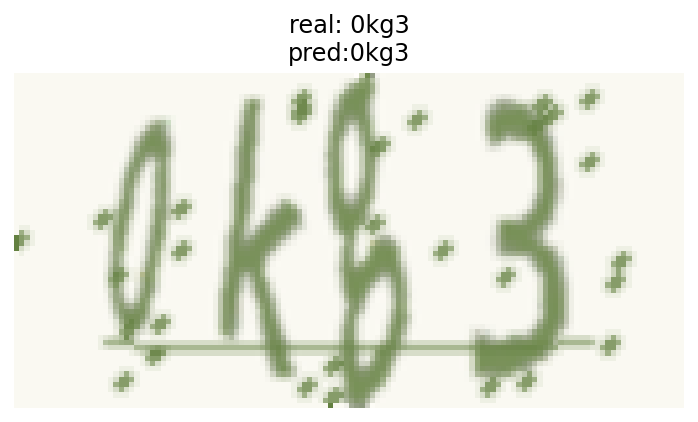

In [ ]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


  1%|          | 1/100 [00:01<01:56,  1.17s/it]

4/4 [==============================] - 0s 9ms/step


  2%|▏         | 2/100 [00:01<01:24,  1.15it/s]

4/4 [==============================] - 0s 10ms/step


  3%|▎         | 3/100 [00:02<01:11,  1.35it/s]

4/4 [==============================] - 0s 14ms/step


  4%|▍         | 4/100 [00:03<01:09,  1.39it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▌         | 5/100 [00:03<01:05,  1.46it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▌         | 6/100 [00:04<01:03,  1.47it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 7/100 [00:05<01:03,  1.46it/s]

4/4 [==============================] - 0s 13ms/step


  8%|▊         | 8/100 [00:05<01:01,  1.50it/s]

4/4 [==============================] - 0s 13ms/step


  9%|▉         | 9/100 [00:06<01:01,  1.47it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 10/100 [00:07<01:01,  1.47it/s]

4/4 [==============================] - 0s 13ms/step


 11%|█         | 11/100 [00:07<01:02,  1.43it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▏        | 12/100 [00:08<01:01,  1.42it/s]

4/4 [==============================] - 0s 13ms/step


 13%|█▎        | 13/100 [00:09<01:00,  1.43it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 14/100 [00:09<01:00,  1.43it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▌        | 15/100 [00:10<00:56,  1.50it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 16/100 [00:11<00:55,  1.52it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 17/100 [00:11<00:52,  1.57it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 18/100 [00:12<00:51,  1.61it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 19/100 [00:12<00:50,  1.62it/s]

4/4 [==============================] - 0s 13ms/step


 20%|██        | 20/100 [00:13<00:50,  1.58it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 21/100 [00:14<00:49,  1.60it/s]

4/4 [==============================] - 0s 13ms/step


 22%|██▏       | 22/100 [00:14<00:48,  1.60it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 23/100 [00:15<00:48,  1.58it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 24/100 [00:16<00:49,  1.54it/s]

4/4 [==============================] - 0s 13ms/step


 25%|██▌       | 25/100 [00:16<00:48,  1.53it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 26/100 [00:17<00:47,  1.57it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 27/100 [00:18<00:47,  1.54it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 28/100 [00:18<00:46,  1.56it/s]

4/4 [==============================] - 0s 13ms/step


 29%|██▉       | 29/100 [00:19<00:44,  1.60it/s]

4/4 [==============================] - 0s 13ms/step


 30%|███       | 30/100 [00:19<00:43,  1.61it/s]

4/4 [==============================] - 0s 13ms/step


 31%|███       | 31/100 [00:20<00:41,  1.65it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 32/100 [00:21<00:41,  1.66it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 33/100 [00:21<00:40,  1.66it/s]

4/4 [==============================] - 0s 13ms/step


 34%|███▍      | 34/100 [00:22<00:39,  1.66it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 35/100 [00:22<00:39,  1.65it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:23<00:41,  1.55it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 37/100 [00:24<00:52,  1.21it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 38/100 [00:25<00:46,  1.32it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 39/100 [00:26<00:43,  1.39it/s]

4/4 [==============================] - 0s 13ms/step


 40%|████      | 40/100 [00:26<00:40,  1.47it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 41/100 [00:27<00:38,  1.53it/s]

4/4 [==============================] - 0s 14ms/step


 42%|████▏     | 42/100 [00:27<00:36,  1.57it/s]

4/4 [==============================] - 0s 13ms/step


 43%|████▎     | 43/100 [00:28<00:35,  1.59it/s]

4/4 [==============================] - 0s 13ms/step


 44%|████▍     | 44/100 [00:29<00:34,  1.60it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 45/100 [00:29<00:33,  1.63it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▌     | 46/100 [00:30<00:32,  1.64it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 47/100 [00:30<00:31,  1.66it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 48/100 [00:31<00:32,  1.61it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▉     | 49/100 [00:32<00:32,  1.56it/s]

4/4 [==============================] - 0s 14ms/step


 50%|█████     | 50/100 [00:32<00:31,  1.59it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 51/100 [00:33<00:31,  1.54it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 52/100 [00:34<00:30,  1.59it/s]

4/4 [==============================] - 0s 13ms/step


 53%|█████▎    | 53/100 [00:34<00:28,  1.63it/s]

4/4 [==============================] - 0s 13ms/step


 54%|█████▍    | 54/100 [00:35<00:28,  1.59it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▌    | 55/100 [00:36<00:27,  1.62it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▌    | 56/100 [00:36<00:26,  1.63it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 57/100 [00:37<00:26,  1.64it/s]

4/4 [==============================] - 0s 13ms/step


 58%|█████▊    | 58/100 [00:37<00:26,  1.58it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 59/100 [00:38<00:26,  1.57it/s]

4/4 [==============================] - 0s 13ms/step


 60%|██████    | 60/100 [00:39<00:25,  1.56it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████    | 61/100 [00:39<00:25,  1.52it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 62/100 [00:40<00:25,  1.50it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 63/100 [00:41<00:23,  1.56it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 64/100 [00:41<00:22,  1.58it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▌   | 65/100 [00:42<00:22,  1.55it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▌   | 66/100 [00:43<00:22,  1.53it/s]

4/4 [==============================] - 0s 13ms/step


 67%|██████▋   | 67/100 [00:43<00:21,  1.56it/s]

4/4 [==============================] - 0s 13ms/step


 68%|██████▊   | 68/100 [00:44<00:20,  1.53it/s]

4/4 [==============================] - 0s 13ms/step


 69%|██████▉   | 69/100 [00:45<00:20,  1.51it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 70/100 [00:45<00:21,  1.36it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 71/100 [00:46<00:20,  1.43it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 72/100 [00:47<00:19,  1.46it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 73/100 [00:48<00:18,  1.43it/s]

4/4 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:49<00:24,  1.07it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 75/100 [00:50<00:26,  1.04s/it]

4/4 [==============================] - 0s 14ms/step


 76%|███████▌  | 76/100 [00:52<00:27,  1.13s/it]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 77/100 [00:53<00:27,  1.17s/it]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 78/100 [00:53<00:21,  1.00it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▉  | 79/100 [00:54<00:18,  1.12it/s]

4/4 [==============================] - 0s 15ms/step


 80%|████████  | 80/100 [00:55<00:16,  1.21it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████  | 81/100 [00:55<00:14,  1.28it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 82/100 [00:56<00:13,  1.32it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 83/100 [00:57<00:12,  1.40it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▍ | 84/100 [00:57<00:10,  1.46it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▌ | 85/100 [00:58<00:09,  1.51it/s]

4/4 [==============================] - 0s 13ms/step


 86%|████████▌ | 86/100 [00:59<00:09,  1.49it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 87/100 [01:00<00:10,  1.29it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 88/100 [01:01<00:10,  1.15it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 89/100 [01:01<00:08,  1.25it/s]

4/4 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [01:02<00:07,  1.33it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 91/100 [01:04<00:09,  1.04s/it]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 92/100 [01:05<00:08,  1.03s/it]

4/4 [==============================] - 0s 13ms/step


 93%|█████████▎| 93/100 [01:05<00:06,  1.12it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 94/100 [01:06<00:04,  1.24it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▌| 95/100 [01:07<00:03,  1.35it/s]

4/4 [==============================] - 0s 13ms/step


 96%|█████████▌| 96/100 [01:07<00:02,  1.40it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 97/100 [01:08<00:02,  1.33it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 98/100 [01:09<00:01,  1.31it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 99/100 [01:10<00:00,  1.24it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


0.997890625

# 保存模型

In [ ]:
model.save('cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

<AxesSubplot: >

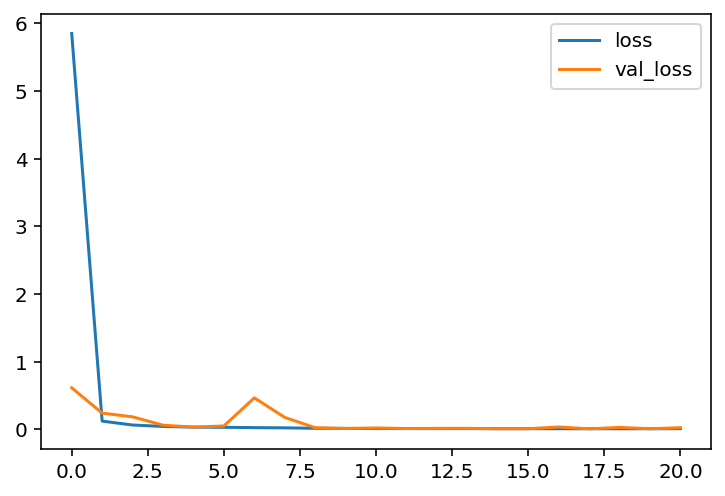

In [ ]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

<AxesSubplot: >

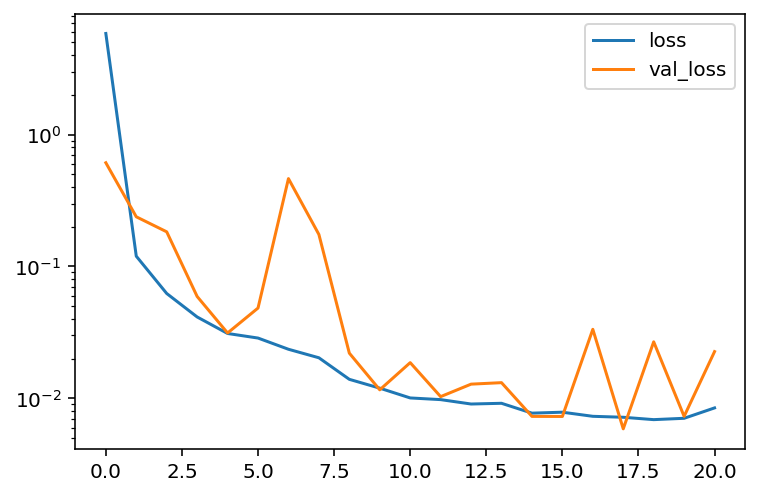

In [ ]:
df[['loss', 'val_loss']].plot(logy=True)